- adjust era5 air temp and wind to simulate Foehn winds 
- increase the air temperature by 5 K 
- increase wind speed by 5 m s−1 
- apply chanages for 18 h in each 52 h period between the months of January and March

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

ds = xr.open_dataset('../data/era5/era5_2013_2024_merged.nc', decode_times=False)

raw_time = ds['valid_time'].values.astype('int64')
time = pd.to_datetime(raw_time, unit='s', errors='coerce')

ds = ds.assign_coords(time=("valid_time", time))
ds = ds.swap_dims({"valid_time": "time"}).drop_vars("valid_time")

# Create a mask for Jan–March 
mask_jfm = ds.time.dt.month.isin([1, 2, 3])

# Create repeating 52-hour cycle: first 18 hours = True
cycle_length = 52
active_hours = 18
cycle_mask = (np.arange(ds.dims['time']) % cycle_length) < active_hours

# Build a combined mask for Jan–March + every first 18 of 52 hours
mask_combined = xr.DataArray(
    mask_jfm.values & cycle_mask,
    dims=['time'],
    coords={'time': ds.time}
)

ds_out = ds.copy()

# add 5 deg K to temperature where mask is True
ds_out['t2m'] = xr.where(mask_combined, ds['t2m'] + 5, ds['t2m'])

u10 = ds['u10']
v10 = ds['v10']
wind_speed = np.sqrt(u10**2 + v10**2)

# Add 5 m/s to wind speed where mask is True
wind_speed_adj = xr.where(mask_combined, wind_speed + 5, wind_speed)

ds_out['u10'] = wind_speed_adj

# monarchs does not care about wind direction so set u10 to zero
# this way the adjustment is to the wind magnitude 
ds_out['v10'] = xr.zeros_like(ds['u10'])

# increase temperature (foehn warming)
ds_out['t2m'] = xr.where(mask_combined, ds['t2m'] + 5, ds['t2m'])

# use for expt_id='era5_2013_2024_03'
ds_out.to_netcdf('../data/era5/era5_2013_2024_merged_foehn_adj.nc')

C:\Users\ik933917\AppData\Local\Temp\ipykernel_26232\2089168154.py:20: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  cycle_mask = (np.arange(ds.dims['time']) % cycle_length) < active_hours


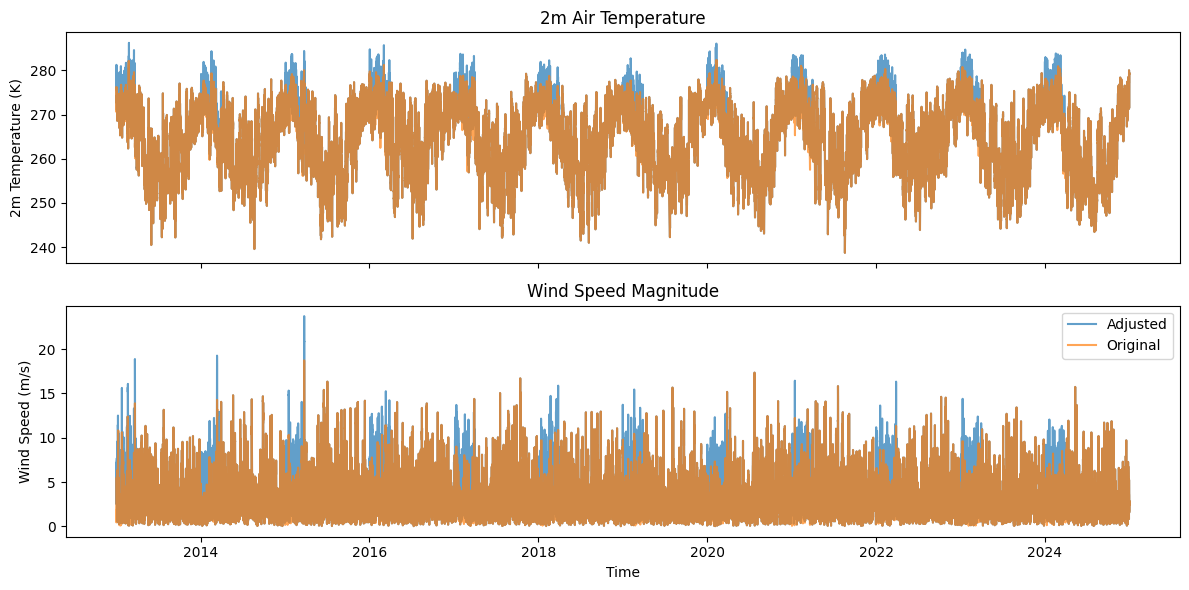

In [48]:
# 2m Temperature 
t2m_orig = ds['t2m'].squeeze().values 
t2m_adj  = ds_out['t2m'].squeeze().values 

# Wind speed magnitude 
u10_orig = ds['u10'].squeeze().values 
v10_orig = ds['v10'].squeeze().values 
wind_orig = np.sqrt(u10_orig**2 + v10_orig**2)

u10_adj = ds_out['u10'].squeeze().values 
v10_adj = ds_out['v10'].squeeze().values 
wind_adj = np.sqrt(u10_adj**2 + v10_adj**2)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot temperature
axes[0].plot(time, t2m_adj, label='Adjusted', alpha=0.7)
axes[0].plot(time, t2m_orig, label='Original', alpha=0.7)
axes[0].set_ylabel("2m Temperature (K)")
axes[0].set_title("2m Air Temperature")


# Plot wind speed
axes[1].plot(time, wind_adj, label='Adjusted', alpha=0.7)
axes[1].plot(time, wind_orig, label='Original', alpha=0.7)
axes[1].set_ylabel("Wind Speed (m/s)")
axes[1].set_title("Wind Speed Magnitude")
axes[1].set_xlabel("Time")
axes[1].legend()

plt.tight_layout()
plt.show()
